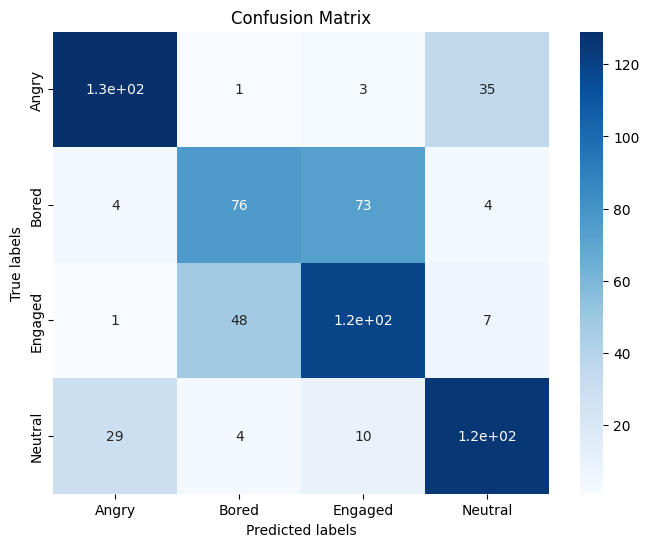

Test accuracy: 67.22%
Macro-average precision: 0.6730
Macro-average recall: 0.6690
Macro-average F1-score: 0.6687

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.77      0.78       168
           1       0.59      0.48      0.53       157
           2       0.58      0.68      0.63       175
           3       0.73      0.74      0.74       168

    accuracy                           0.67       668
   macro avg       0.67      0.67      0.67       668
weighted avg       0.67      0.67      0.67       668



In [1]:
import torch
import numpy as np
import torch.nn as nn
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from DataLoder.dataLoader import custom_loader
import matplotlib.pyplot as plt
import seaborn as sns

# Import from structured project directories
from Model.model import MultiLayerFCNet
from DataLoder.dataLoader import custom_loader
import Config.config as config
from Utils.utils import load_model , load_model_for_testing

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize the model
model = MultiLayerFCNet(config.INPUT_SIZE, config.HIDDEN_SIZE, config.OUTPUT_SIZE)

# Wrap the model with nn.DataParallel if using multiple GPUs
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

# Load the saved model
model = load_model_for_testing(model, config.MODEL_SAVE_PATH).to(device)

# Set the model to evaluation mode
model.eval()

# Test dataset loading
normalize = transforms.Normalize(mean=[0.5836, 0.4212, 0.3323], std=[0.2325, 0.1985, 0.1722])
transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    normalize
])

test_dataset = ImageFolder(config.TEST_DATA_PATH, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=config.TEST_BATCH_SIZE, shuffle=False)

# Calculate the test accuracy
correct = 0
total = 0
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)
class_report = classification_report(all_labels, all_preds)
precision, recall, f1_score, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')

# Plotting Confusion Matrix
classes = test_dataset.classes
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Displaying results
print(f'Test accuracy: {accuracy * 100:.2f}%')
print(f'Macro-average precision: {precision:.4f}')
print(f'Macro-average recall: {recall:.4f}')
print(f'Macro-average F1-score: {f1_score:.4f}')
print("\nClassification Report:")
print(class_report)
